# **Meta 1**

 Incluir obstáculos retangulares no espaço de trabalho simulado no 
CoppeliaSim. Considerando que o robô seja de forma quadrada e 
sua orientação não mude, obter o mapa correspondente em espaço 
de configuração. Incluir funcionalidade que permita apresentar o 
caminho do robô.

Obs.: Inserir as seguintes linhas ao script do robô para ser desenhado o caminho

```lua
--lua

sim = require('sim')

function sysCall_init()
    robot = sim.getObject('.')
    robotTrace = sim.addDrawingObject(sim.drawing_linestrip + sim.drawing_cyclic, 8, 0, -1, 400, {1, 1, 0}, nil, nil, {1, 1, 0})
end

function sysCall_sensing()
    local p = sim.getObjectPosition(robot)
    p[3]=0
    sim.addDrawingObjectItem(robotTrace, p)
end 
```


In [1]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import numpy as np
import matplotlib.pyplot as plt
import guira

Program started
Connected to remote API server
Número de objetos na simulação: 186
Erro ao obter as dimensões do objeto 0
Erro ao obter min_x para o objeto 1
Erro ao obter as dimensões do objeto 1
Erro ao obter min_x para o objeto 2
Erro ao obter as dimensões do objeto 2
Erro ao obter min_x para o objeto 3
Erro ao obter as dimensões do objeto 3
Erro ao obter min_x para o objeto 4
Erro ao obter as dimensões do objeto 4
Erro ao obter min_x para o objeto 5
Erro ao obter as dimensões do objeto 5
Erro ao obter min_x para o objeto 6
Erro ao obter as dimensões do objeto 6
Erro ao obter min_x para o objeto 7
Erro ao obter as dimensões do objeto 7
Erro ao obter as dimensões do objeto 8
Erro ao obter min_x para o objeto 9
Erro ao obter as dimensões do objeto 9
Erro ao obter min_x para o objeto 10
Erro ao obter as dimensões do objeto 10
Erro ao obter min_x para o objeto 11
Erro ao obter as dimensões do objeto 11
Erro ao obter min_x para o objeto 12
Erro ao obter as dimensões do objeto 12
Ignorand

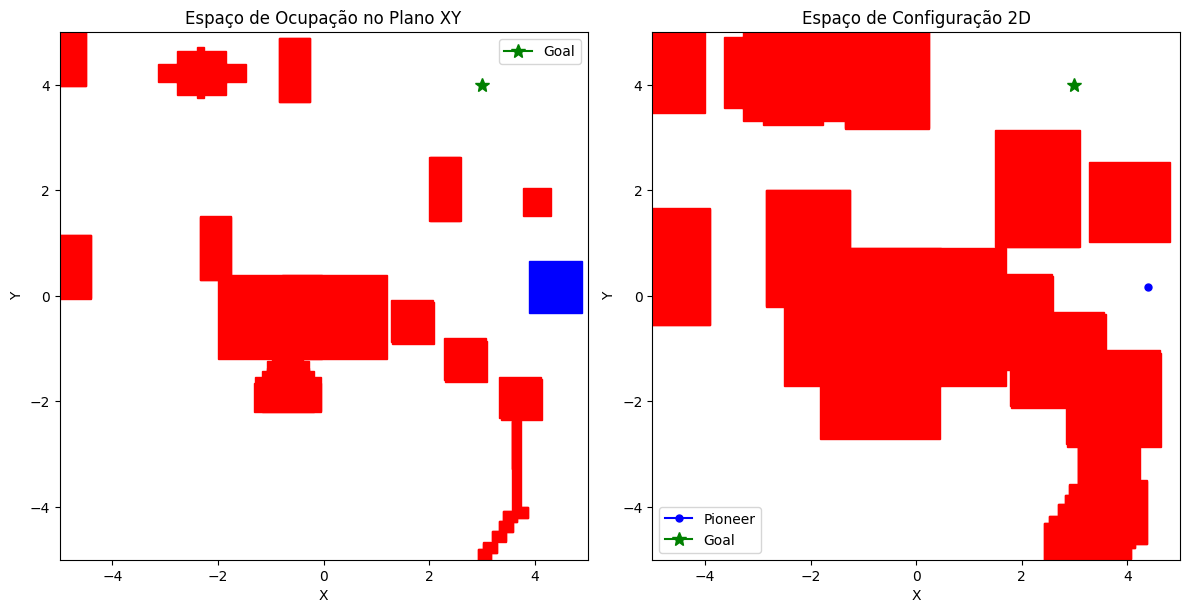

Program ended


In [2]:
from RobotLibrary import *

print('Program started')
sim.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID != -1:
    print('Connected to remote API server')
    controller = RobotController(clientID)

    controller.set_goal(np.array([3,4,0]))

    controller.get_map()

    controller.plot_map()
    
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')

print('Program ended')

Program started
Connected to remote API server


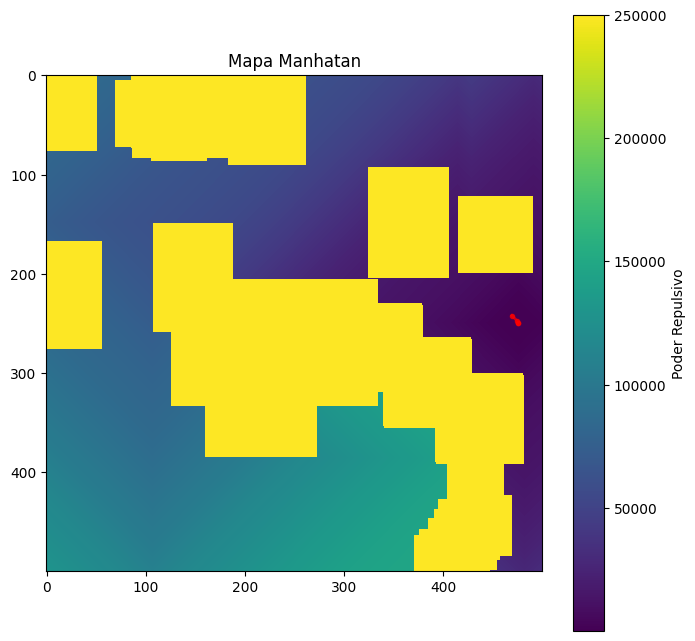

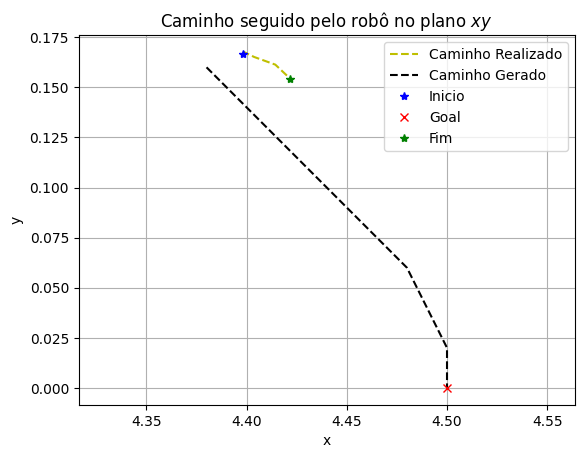

Program ended


In [3]:
from RobotLibrary import *

print('Program started')
sim.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID != -1:
    print('Connected to remote API server')

    controller.set_goal(np.array([4.5,0,0]))
    
    controller.get_generated_path_manha(True)

    controller.send_generated_path()

    controller.control_loop(500)
    
    sim.simxFinish(clientID)
    
    controller.plot_caminho()
else:
    print('Failed connecting to remote API server')

print('Program ended')

Program started
Connected to remote API server


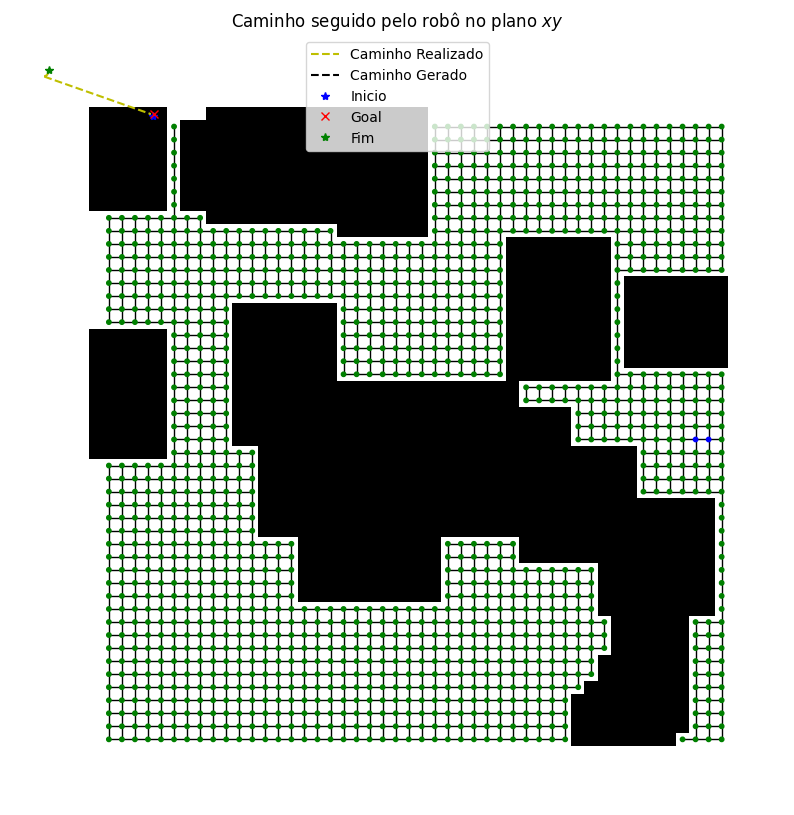

Program ended


In [6]:
from RobotLibrary import *

print('Program started')
sim.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID != -1:
    print('Connected to remote API server')

    controller.set_goal(np.array([4.5,0,0]))
    
    controller.get_generated_path_graph()

    controller.send_generated_path()

    controller.control_loop(500)
    
    controller.plot_caminho()

    
    sim.simxFinish(clientID)
    
else:
    print('Failed connecting to remote API server')

print('Program ended')